In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Mon Sep 15 20:15:51 PDT 2025
abie
/mnt/share/homes/abie/notebook/2025


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
locations = ['united_states_of_america',
             'china',
             'brazil',
#              'japan',
             'sweden',
             'united_kingdom',
            ]



results_dirs = [
    'results/model4.1/united_states_of_america/2025_09_12_11_50_31/results/',
    'results/model4.1/china/2025_09_12_13_08_37/results/',
    'results/model4.1/brazil/2025_09_12_15_52_40/results/',
#     'results/model4.1/japan/2025_09_12_16_52_42/results/',
    'results/model4.1/sweden/2025_09_12_14_14_04/results/',
    'results/model4.1/united_kingdom/2025_09_12_15_01_38/results/'
]

artifact_dirs = ['artifacts/model4.1/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model4.1/united_states_of_america.hdf',
 'artifacts/model4.1/china.hdf',
 'artifacts/model4.1/brazil.hdf',
 'artifacts/model4.1/sweden.hdf',
 'artifacts/model4.1/united_kingdom.hdf']

In [4]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [5]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [6]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        
        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['current_year'] = temp['current_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [7]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [8]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [9]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        4.900711e+08
alzheimers_disease_state                      1.635629e+09
alzheimers_mild_cognitive_impairment_state    6.816800e+08
Name: value, dtype: float64

In [10]:
person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                                       alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
Brazil                   2025         30_to_34                              4862.464066   
                                      35_to_39                              5632.542094   
                                      40_to_44                              5615.006160   
                                      45_to_49                             17323.498973   
                                      50_to_54                             31646.349076   
...                                                                                 ...   
United_States_Of_America 2100         75_to_79                            174452.484600   
                                      80_to_84                            202493.445585   
                                      85_to_89                            189265.839836   
                                      90_to_94                            191451.318275   
                                      95_plus                             213134.751540   

sub_entity                                       alzheimers_disease_state  \
location                 current_year age_group                             
Brazil                   2025         30_to_34                 311.638604   
                                      35_to_39                 355.227926   
                                      40_to_44                 329.675565   
                                      45_to_49                1134.825462   
                                      50_to_54                2397.412731   
...                                                                   ...   
United_States_Of_America 2100         75_to_79              499618.809035   
                                      80_to_84              728742.825462   
                                      85_to_89              825443.983573   
                                      90_to_94              705899.515400   
                                      95_plus               684279.712526   

sub_entity                                       alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
Brazil                   2025         30_to_34                                  4959.663244  
                                      35_to_39                                  5624.024641  
                                      40_to_44                                  5590.956879  
                                      45_to_49                                 17436.229979  
                                      50_to_54                                 32162.406571  
...                                                                                     ...  
United_States_Of_America 2100         75_to_79                                233556.599589  
                                      80_to_84                                293663.770021  
                                      85_to_89                                285245.519507  
                                      90_to_94                                252585.092402  
                                      95_plus                                 283738.932238  

[5320 rows x 3 columns]

In [11]:
assert np.all(person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [12]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [13]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [14]:
assert np.all(trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [15]:
out_counts = trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
out_counts

alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
Brazil                   2025         30_to_34                                    532.0   
                                      35_to_39                                    720.0   
                                      40_to_44                                    662.0   
                                      45_to_49                                   1845.0   
                                      50_to_54                                   3599.0   
...                                                                                 ...   
United_States_Of_America 2100         75_to_79                                  31721.0   
                                      80_to_84                                  40651.0   
                                      85_to_89                                  38273.0   
                                      90_to_94                                  30471.0   
                                      95_plus                                   39340.0   

                                                 alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
Brazil                   2025         30_to_34                                       1163.0  
                                      35_to_39                                       1429.0  
                                      40_to_44                                       1407.0  
                                      45_to_49                                       4131.0  
                                      50_to_54                                       7842.0  
...                                                                                     ...  
United_States_Of_America 2100         75_to_79                                      57551.0  
                                      80_to_84                                      73674.0  
                                      85_to_89                                      71485.0  
                                      90_to_94                                      61212.0  
                                      95_plus                                       70100.0  

[5320 rows x 2 columns]

In [16]:
out_rates = out_counts / person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_rates['alzheimers_blood_based_biomarker_state'].unstack()

age_group                              30_to_34  35_to_39  40_to_44  45_to_49  \
location                 current_year                                           
Brazil                   2025          0.109410  0.127829  0.117898  0.106503   
                         2026          0.175312  0.195742  0.139798  0.154952   
                         2027          0.214312  0.239867  0.166008  0.159334   
                         2028          0.203562  0.260711  0.183337  0.163142   
                         2029          0.064818  0.249399  0.191816  0.162692   
...                                         ...       ...       ...       ...   
United_States_Of_America 2096          0.084495  0.118132  0.170461  0.175237   
                         2097          0.086465  0.125122  0.162018  0.185754   
                         2098          0.077733  0.114761  0.159889  0.185443   
                         2099          0.058970  0.107603  0.169424  0.188649   
                         2100          0.064682  0.128928  0.170479  0.187376   

age_group                              50_to_54  55_to_59  60_to_64  65_to_69  \
location                 current_year                                           
Brazil                   2025          0.113726  0.113310  0.115711  0.116183   
                         2026          0.172555  0.178251  0.177324  0.178278   
                         2027          0.204335  0.211186  0.215914  0.211139   
                         2028          0.213732  0.223364  0.227606  0.225188   
                         2029          0.201666  0.215169  0.215289  0.213582   
...                                         ...       ...       ...       ...   
United_States_Of_America 2096          0.189155  0.182191  0.173417  0.169685   
                         2097          0.181802  0.183237  0.172809  0.169485   
                         2098          0.174688  0.179815  0.172725  0.167951   
                         2099          0.184116  0.184652  0.175503  0.169224   
                         2100          0.182293  0.182444  0.177023  0.167707   

age_group                              70_to_74  75_to_79  80_to_84  85_to_89  \
location                 current_year                                           
Brazil                   2025          0.117210  0.120135  0.122742  0.123065   
                         2026          0.180098  0.187740  0.197220  0.196406   
                         2027          0.216650  0.232736  0.249845  0.248080   
                         2028          0.227169  0.250015  0.272583  0.270879   
                         2029          0.216971  0.237966  0.260852  0.262072   
...                                         ...       ...       ...       ...   
United_States_Of_America 2096          0.169972  0.184365  0.200266  0.201779   
                         2097          0.171638  0.186284  0.201124  0.201190   
                         2098          0.171363  0.184075  0.199076  0.201735   
                         2099          0.167756  0.183019  0.200104  0.200437   
                         2100          0.170643  0.181832  0.200752  0.202218   

age_group                              90_to_94   95_plus  
location                 current_year                      
Brazil                   2025          0.119716  0.133508  
                         2026          0.174060  0.102588  
                         2027          0.207333  0.114112  
                         2028          0.219191  0.148711  
                         2029          0.212203  0.180153  
...                                         ...       ...  
United_States_Of_America 2096          0.160160  0.185583  
                         2097          0.156199  0.184268  
                         2098          0.159603  0.183492  
                         2099          0.159132  0.183477  
                         2100          0.159158  0.184578  

[380 rows x 14 columns]

In [17]:
1/3.85

0.2597402597402597

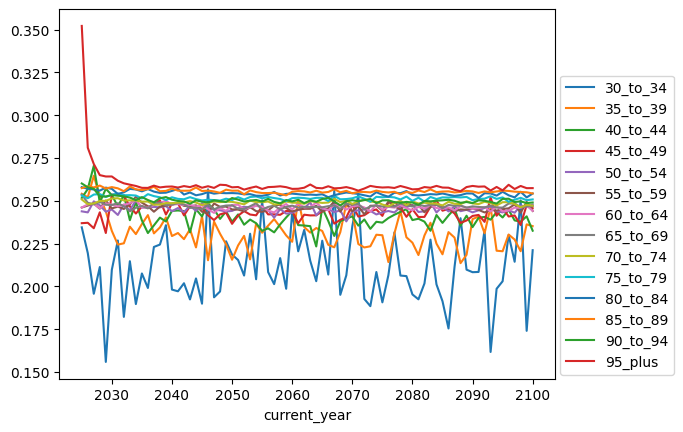

In [18]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
t.loc['Brazil'].plot()
plt.legend(loc=(1.01, .01));

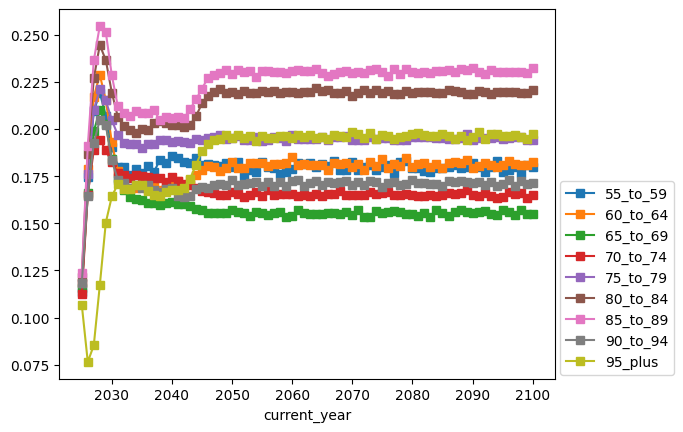

In [19]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
t.loc['China'].iloc[:,5:15].plot(marker='s')
plt.legend(loc=(1.01, .01));

In [20]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
mci_duration_est

location                  current_year  age_group
Brazil                    2025          30_to_34     9.322675
                                        35_to_39     7.811145
                                        40_to_44     8.445554
                                        45_to_49     9.450531
                                        50_to_54     8.936484
                                                       ...   
United_States_Of_America  2100          75_to_79     7.362838
                                        80_to_84     7.224023
                                        85_to_89     7.452918
                                        90_to_94     8.289360
                                        95_plus      7.212479
Length: 5320, dtype: float64

In [21]:
new_sims = load_df('new_simulants').groupby(['location', 'current_year', 'age_group', ]).value.sum()
# new_sims


bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims
)
bbbm_duration_est

location                  current_year  age_group
Brazil                    2025          30_to_34     8.921952
                                        35_to_39     2.458552
                                        40_to_44     1.183851
                                        45_to_49     2.196462
                                        50_to_54     2.467167
                                                       ...   
United_States_Of_America  2100          75_to_79     1.585499
                                        80_to_84     1.532172
                                        85_to_89     1.354521
                                        90_to_94     0.999104
                                        95_plus      1.109979
Length: 5320, dtype: float64

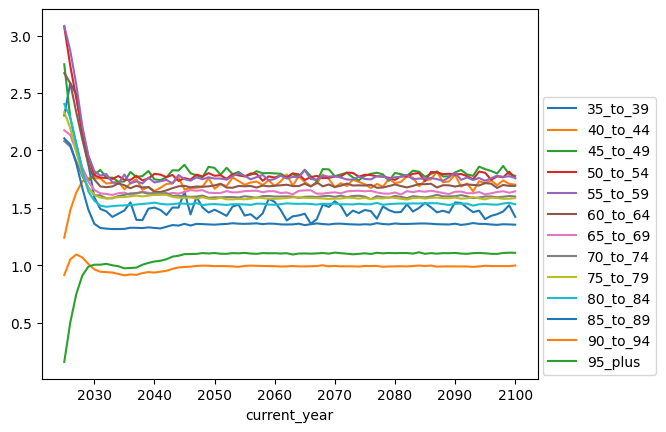

In [22]:
t = bbbm_duration_est.unstack()
t.loc['United_States_Of_America'].iloc[:, 1:].plot()
plt.legend(loc=(1.01, .01));

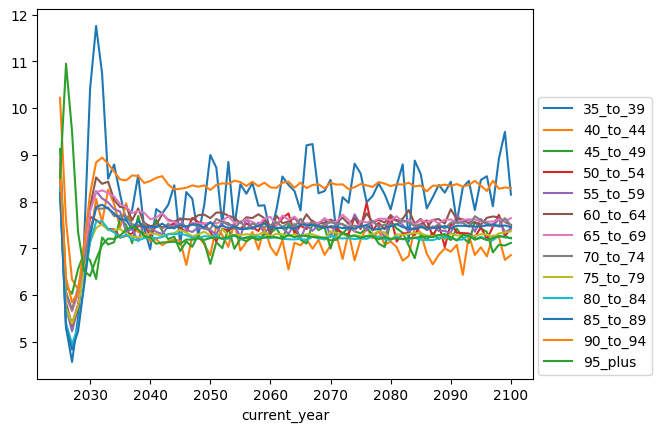

In [23]:
t = mci_duration_est.unstack()
t.loc['United_States_Of_America'].iloc[:, 1:].plot()
plt.legend(loc=(1.01, .01));

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [24]:
%%time

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

CPU times: user 1min, sys: 325 ms, total: 1min
Wall time: 1min


In [25]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2022,2023,0.000931,0.000911,0.000951,11,30 to 34,30_to_34,acmr,United_States_Of_America
1,Female,30.0,35.0,2023,2024,0.000898,0.000875,0.000925,11,30 to 34,30_to_34,acmr,United_States_Of_America
2,Female,30.0,35.0,2024,2025,0.000900,0.000871,0.000935,11,30 to 34,30_to_34,acmr,United_States_Of_America
3,Female,30.0,35.0,2025,2026,0.000901,0.000865,0.000942,11,30 to 34,30_to_34,acmr,United_States_Of_America
4,Female,30.0,35.0,2026,2027,0.000902,0.000856,0.000950,11,30 to 34,30_to_34,acmr,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,Male,95.0,125.0,2046,2047,0.272664,0.221753,0.318492,33,95 to 99,95_plus,acmr,United_Kingdom
808,Male,95.0,125.0,2047,2048,0.272193,0.223153,0.318111,33,95 to 99,95_plus,acmr,United_Kingdom
809,Male,95.0,125.0,2048,2049,0.271928,0.223803,0.319848,33,95 to 99,95_plus,acmr,United_Kingdom
810,Male,95.0,125.0,2049,2050,0.271906,0.223126,0.320114,33,95 to 99,95_plus,acmr,United_Kingdom


In [26]:
art_data = art_ocmr
location = 'China'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [27]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


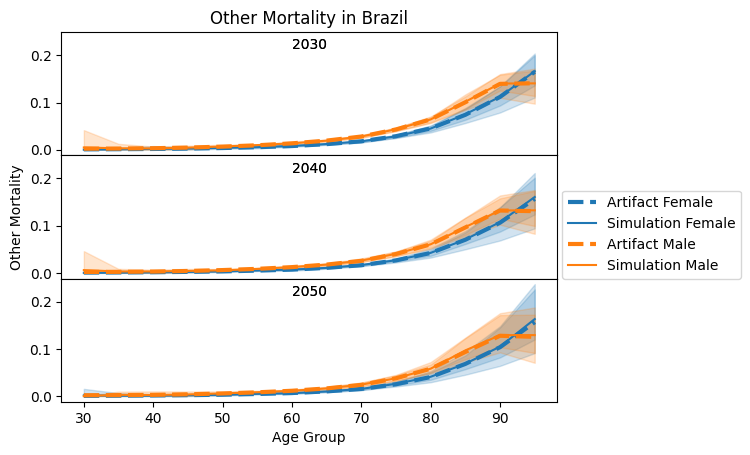

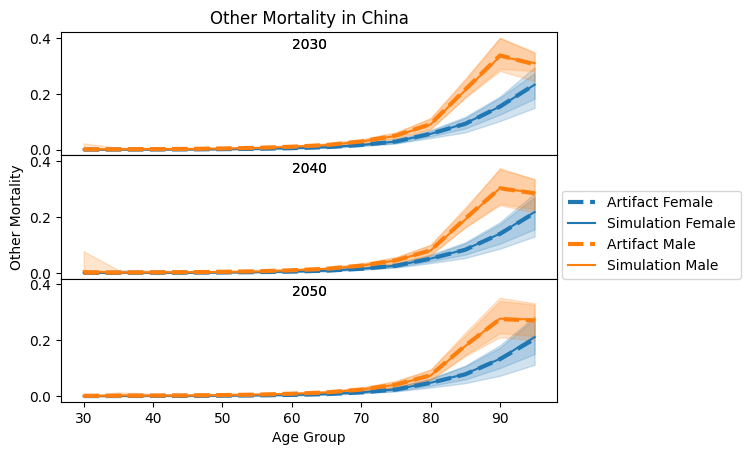

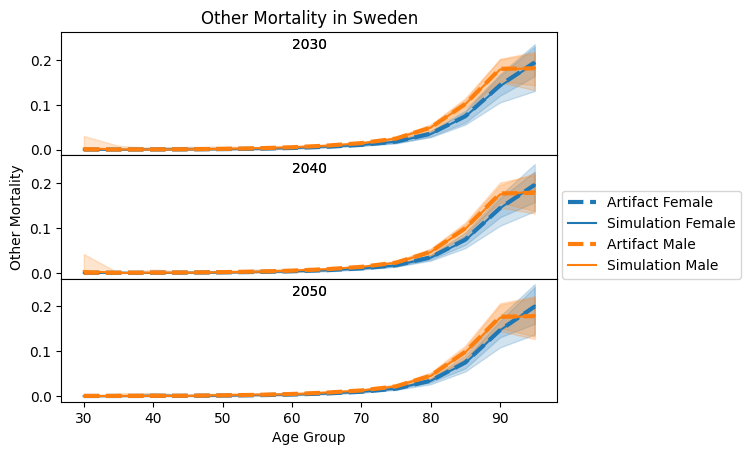

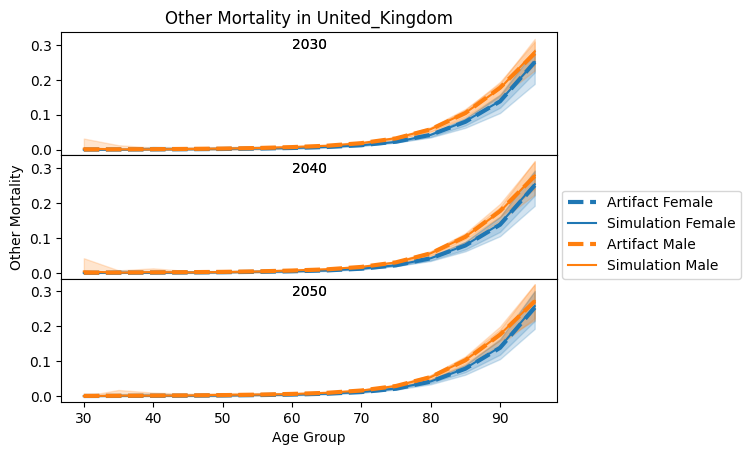

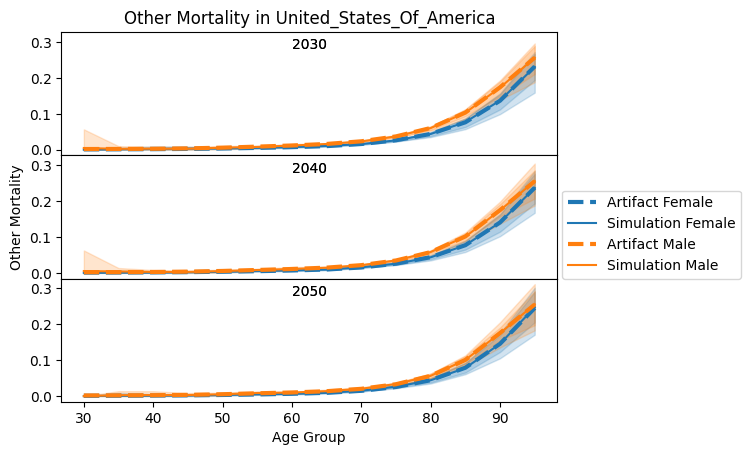

In [28]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [29]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

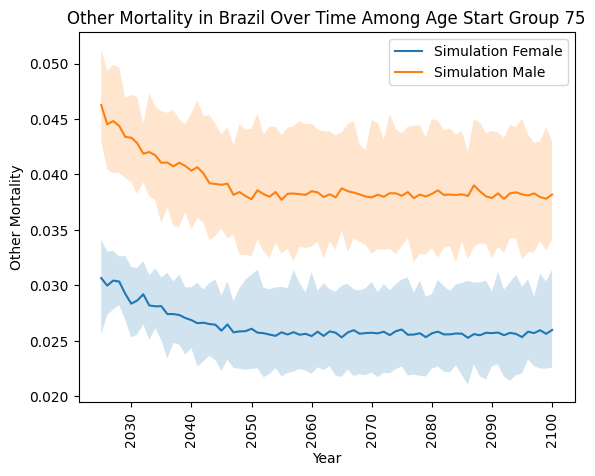

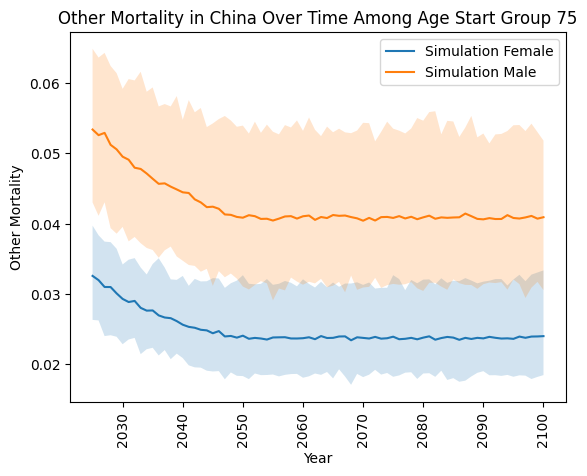

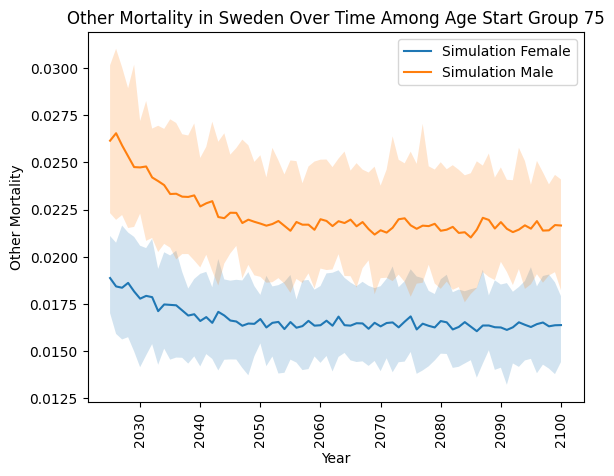

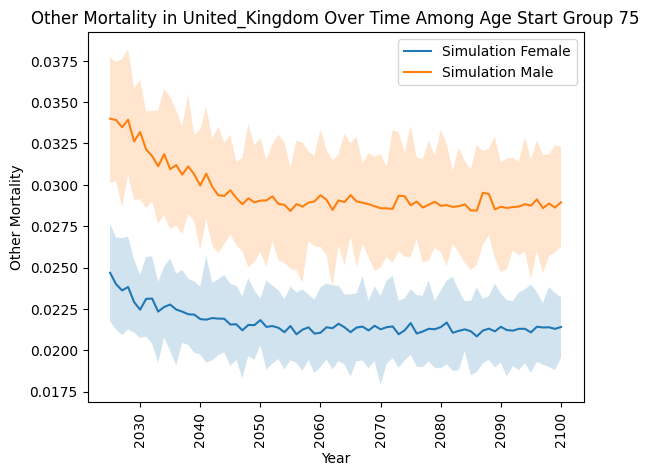

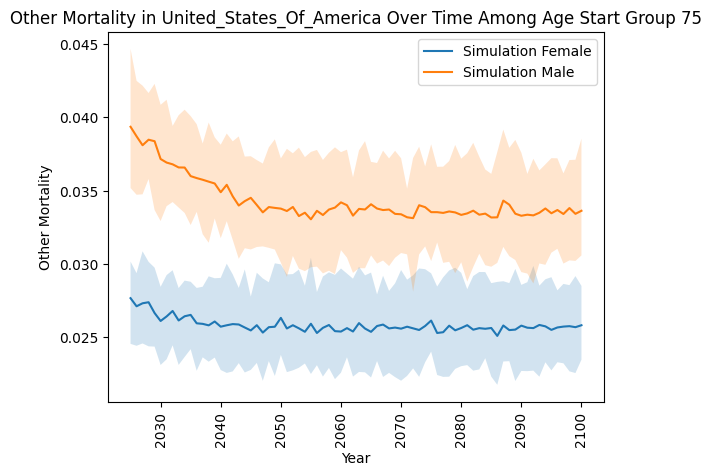

<Figure size 640x480 with 0 Axes>

In [30]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [31]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

In [32]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [33]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

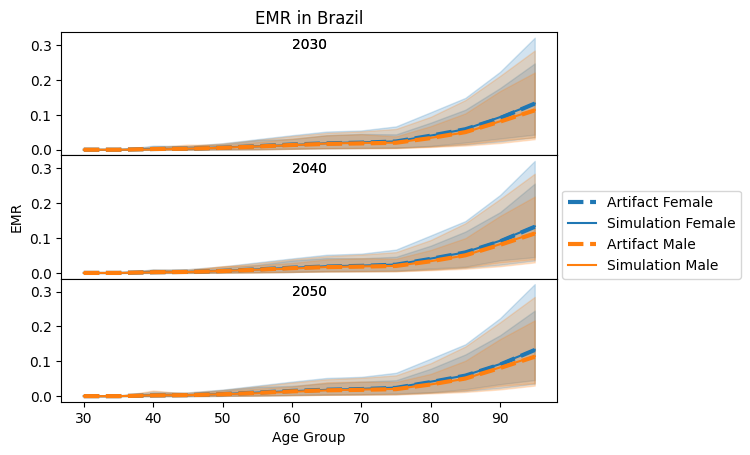

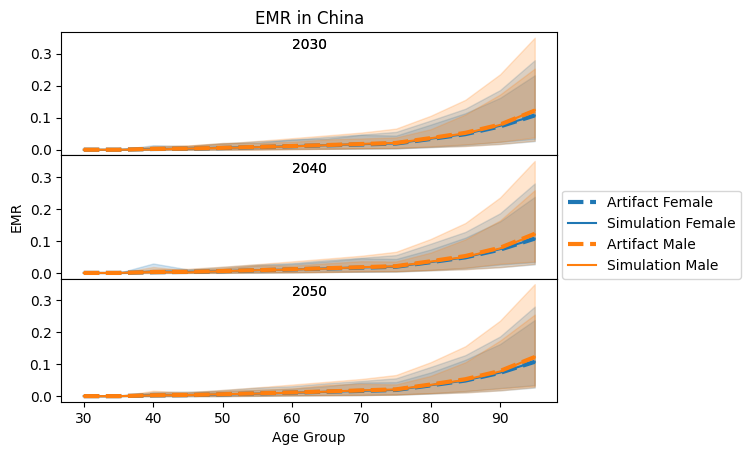

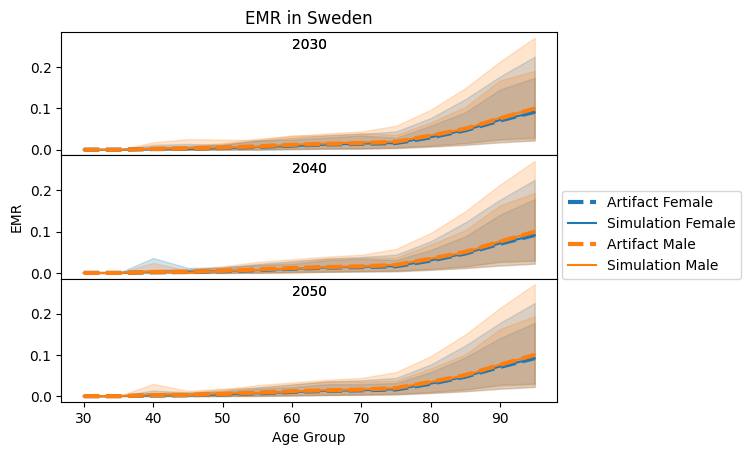

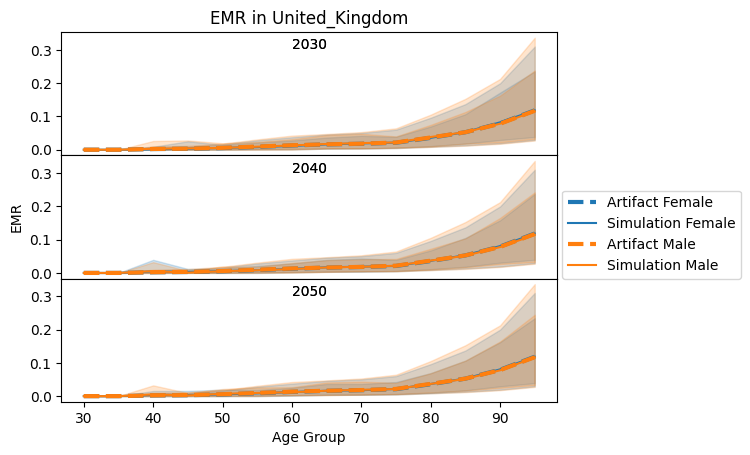

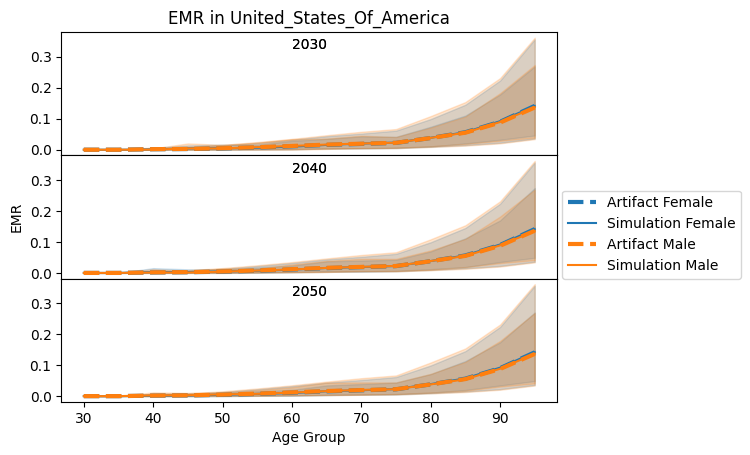

In [34]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

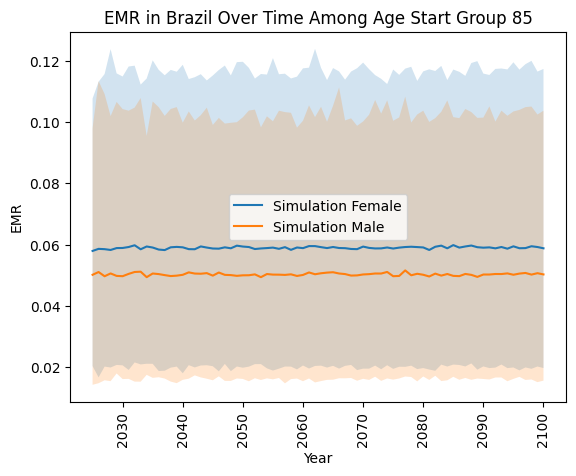

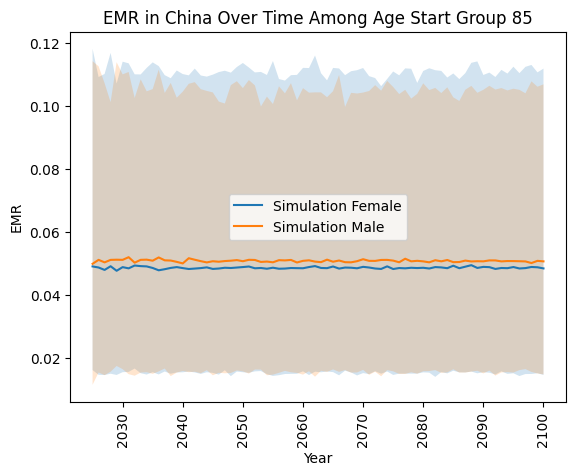

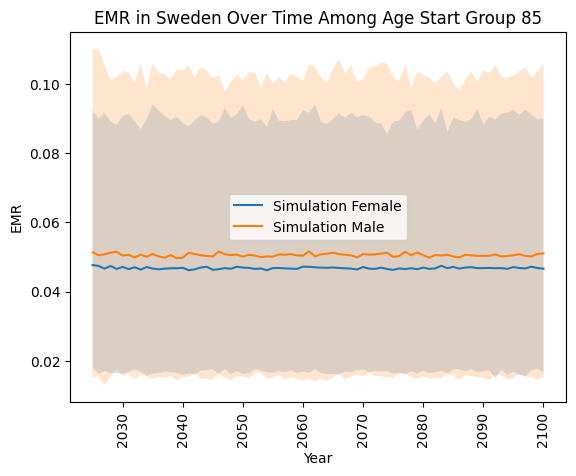

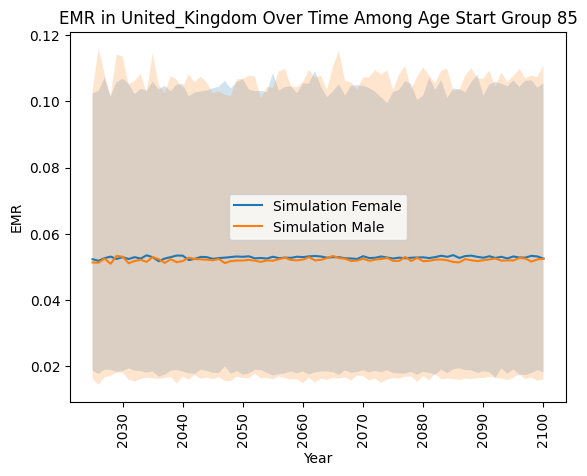

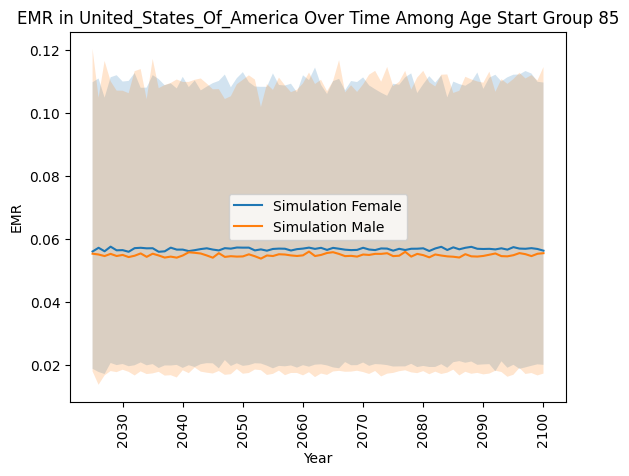

<Figure size 640x480 with 0 Axes>

In [35]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [36]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers_disease_and_other_dementias.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
    

In [37]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2021"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [38]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Brazil,168.0,0.004094,6.943028e-19,0.004094,0.004094,0.004094,0.004094,0.004094
China,168.0,0.000438,1.735757e-19,0.000438,0.000438,0.000438,0.000438,0.000438
Sweden,168.0,0.040615,1.666327e-17,0.040615,0.040615,0.040615,0.040615,0.040615
United_Kingdom,168.0,0.008383,2.777211e-18,0.008383,0.008383,0.008383,0.008383,0.008383
United_States_Of_America,168.0,0.001602,3.471514e-19,0.001602,0.001602,0.001602,0.001602,0.001602


In [39]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
# new_sims

In [40]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

In [41]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','current_year']])

In [42]:
# new_sims

In [43]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [44]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,Brazil,30_to_34,Female,25.0,1150.991996,541.827873,195.414600,195.414600,1074.780302,2247.267905,2540.389805,11,30 to 34,30.0,35.0
1,2025,Brazil,30_to_34,Male,25.0,1121.679806,484.136140,195.414600,224.726790,1025.926652,2022.541114,2051.853304,11,30 to 34,30.0,35.0
2,2025,China,30_to_34,Female,25.0,6106.505751,3196.467876,0.000000,1919.709892,5027.811622,12158.162649,15997.582432,11,30 to 34,30.0,35.0
3,2025,China,30_to_34,Male,25.0,5777.412627,2844.894204,1371.221351,1645.465622,5484.885405,11335.429838,13255.139730,11,30 to 34,30.0,35.0
4,2025,Sweden,30_to_34,Female,25.0,39.197712,17.495835,14.773007,14.773007,34.470350,78.789370,93.562377,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,2050,Sweden,95_plus,Male,25.0,5200.689371,1420.808318,3082.634120,3180.135966,5116.384745,8075.910473,9169.112989,33,95 to 99,95.0,125.0
3636,2050,United_Kingdom,95_plus,Female,25.0,47483.898453,13761.968959,24239.137841,26615.336787,45686.957643,75928.622139,89441.464337,33,95 to 99,95.0,125.0
3637,2050,United_Kingdom,95_plus,Male,25.0,23599.759008,6445.470818,12167.283759,13384.012135,23380.270752,35905.415798,43205.786053,33,95 to 99,95.0,125.0
3638,2050,United_States_Of_America,95_plus,Female,25.0,213438.275703,61474.792370,106224.836614,121578.132623,208455.319795,334327.382359,417534.757314,33,95 to 99,95.0,125.0


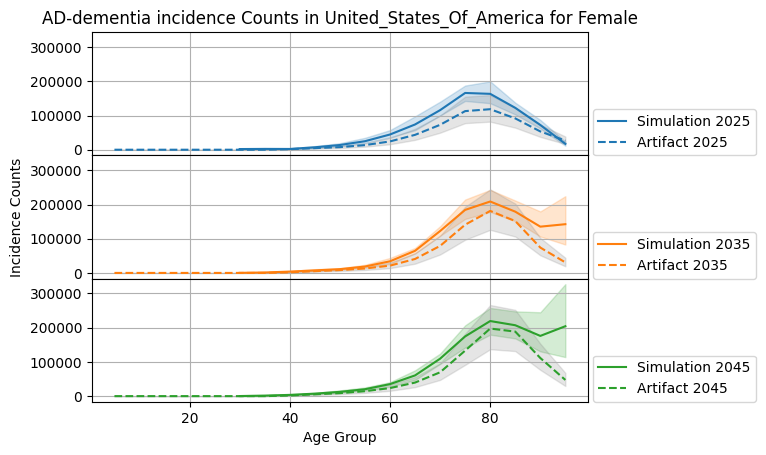

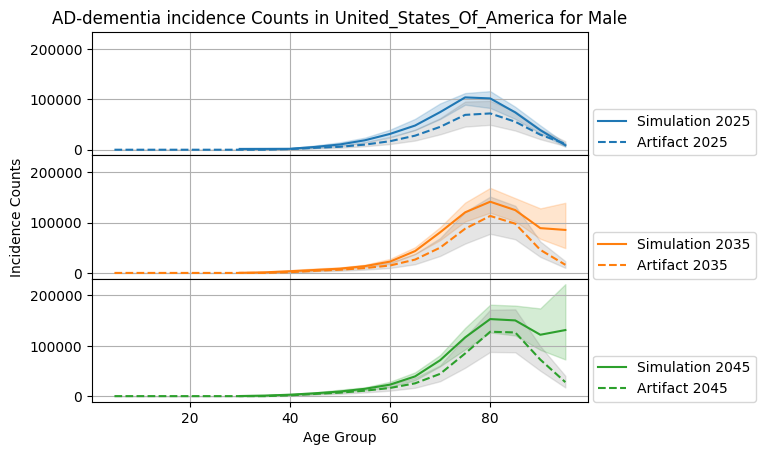

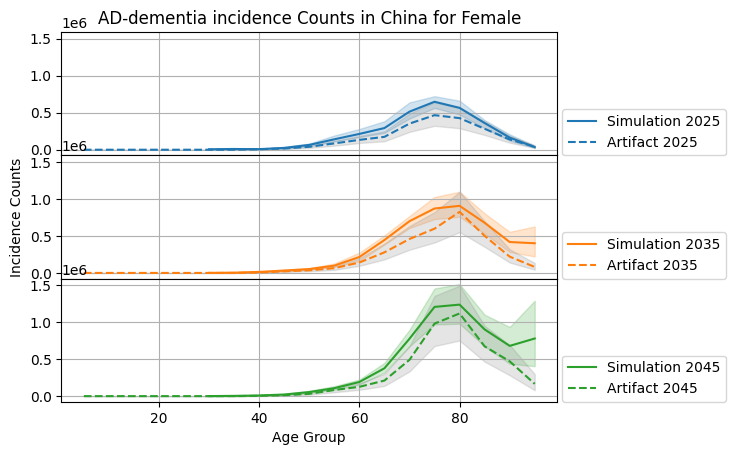

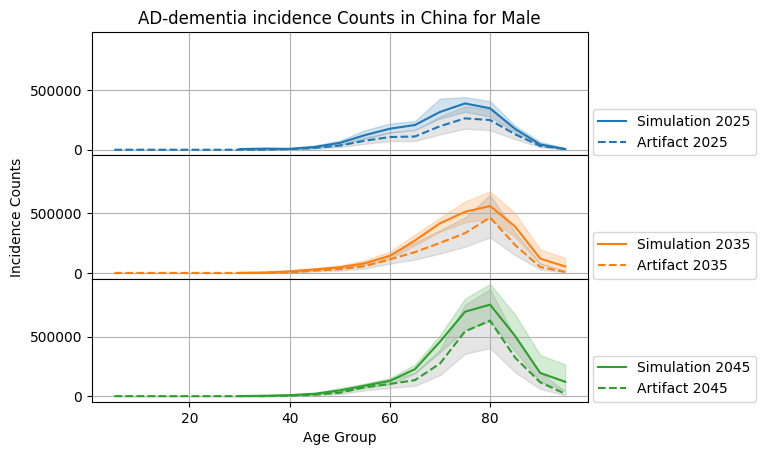

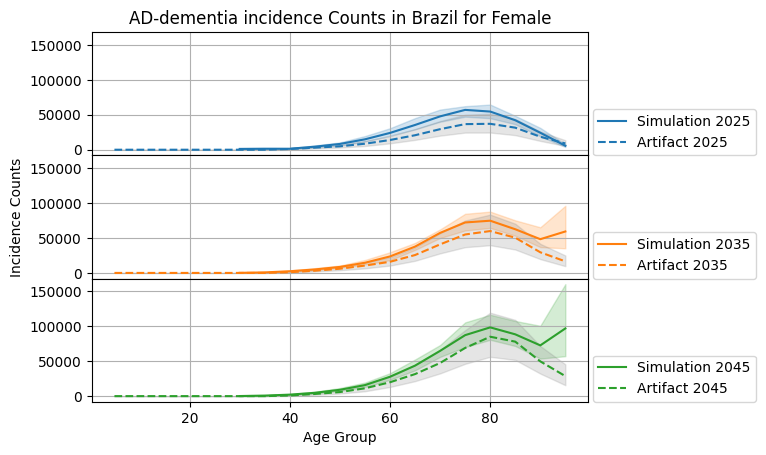

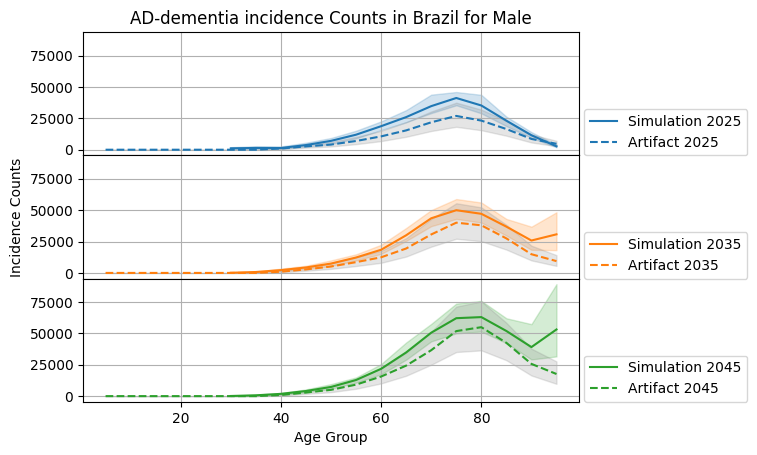

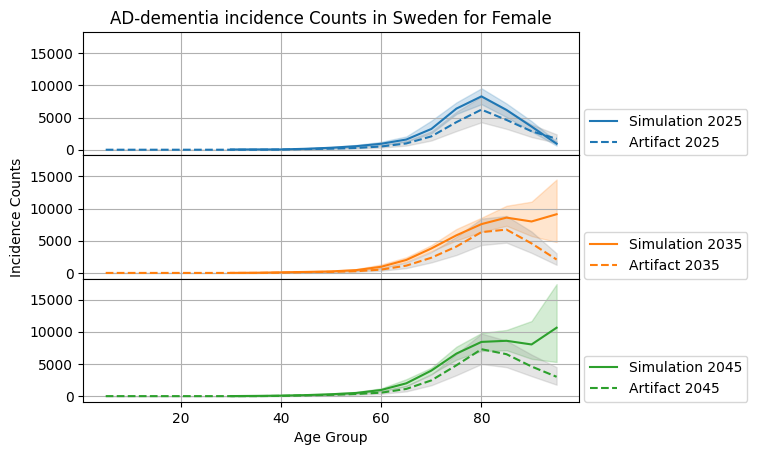

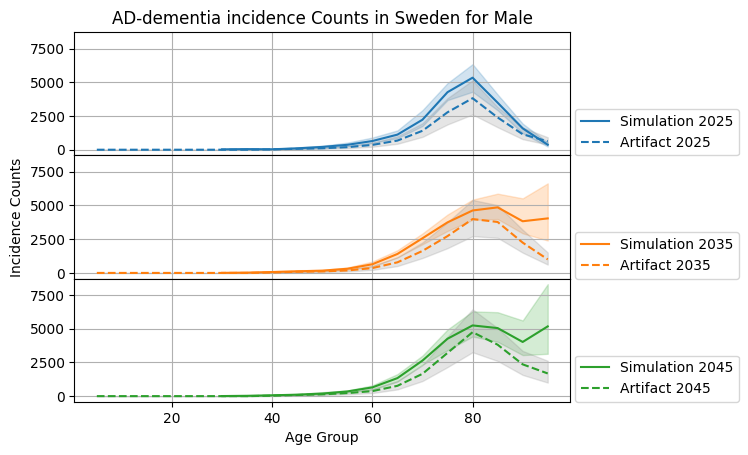

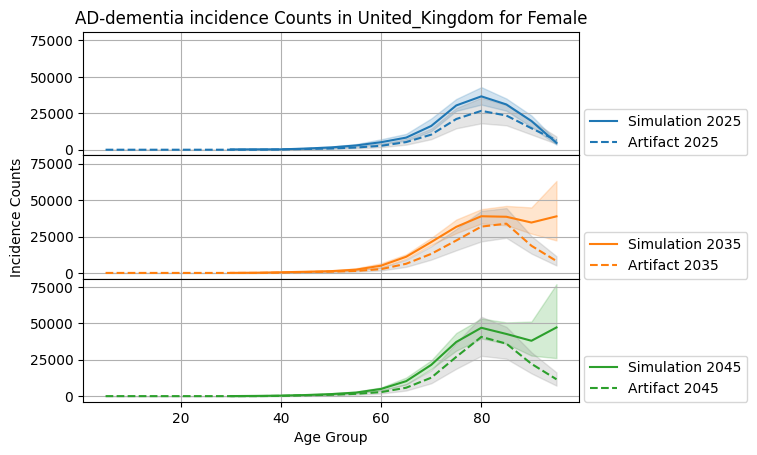

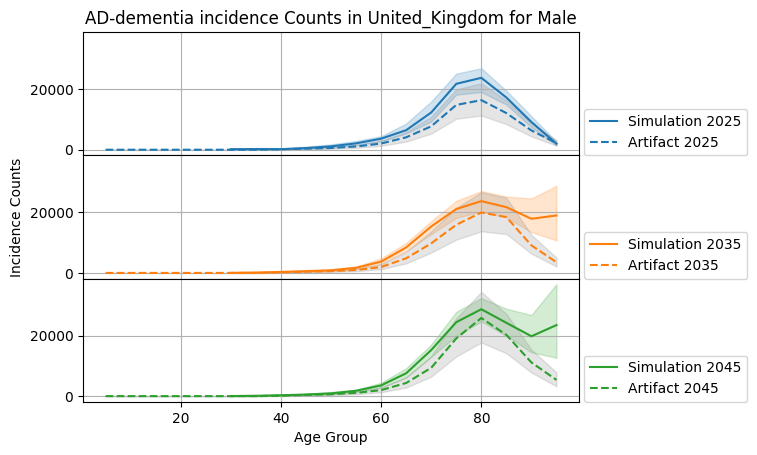

In [45]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and current_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))


## Verifying Prevalence

In [46]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'population.scaling_factor'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United Kingdom           2046       2047      53987.411482   
                                                  2047       2048      53908.630266   
                                                  2048       2049      53507.382181   
                                                  2049       2050      53319.559625   
                                                  2050       2051      53506.547306   

                                                                             draw_1  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United Kingdom           2046       2047      68146.916077   
                                                  2047       2048      68486.724154   
                                                  2048       2049      68631.672056   
                                                  2049       2050      68781.108488   
                                                  2050       2051      69420.899232   

                                                                            draw_10  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United Kingdom           2046       2047      55481.629602   
                                                  2047       2048      55555.874730   
                                                  2048       2049      55303.352398   
                                                  2049       2050      55063.535626   
                                                  2050       2051      55158.686606   

                                                                            draw_100  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                              

In [47]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
3635,2050,Sweden,95_plus,Male,25.0,8.743752e+04,2.531799e+04,4.660585e+04,4.805954e+04,8.730764e+04,1.336081e+05,1.437676e+05,33,95 to 99,95.0,125.0
3636,2050,United_Kingdom,95_plus,Female,25.0,8.083875e+05,2.366371e+05,3.457464e+05,4.194594e+05,7.887919e+05,1.306796e+06,1.421152e+06,33,95 to 99,95.0,125.0
3637,2050,United_Kingdom,95_plus,Male,25.0,3.607783e+05,1.023231e+05,1.496780e+05,1.829414e+05,3.652780e+05,5.568974e+05,6.439789e+05,33,95 to 99,95.0,125.0
3638,2050,United_States_Of_America,95_plus,Female,25.0,3.603358e+06,1.048909e+06,1.459557e+06,1.875022e+06,3.529316e+06,5.606817e+06,6.278946e+06,33,95 to 99,95.0,125.0
3639,2050,United_States_Of_America,95_plus,Male,25.0,2.189170e+06,6.764740e+05,9.092680e+05,1.188859e+06,2.121229e+06,3.537033e+06,4.171601e+06,33,95 to 99,95.0,125.0


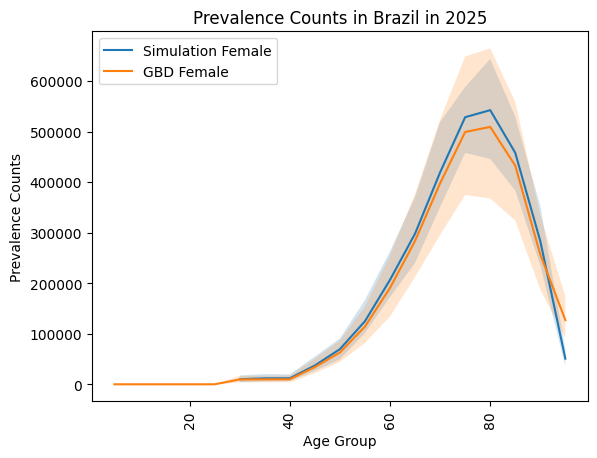

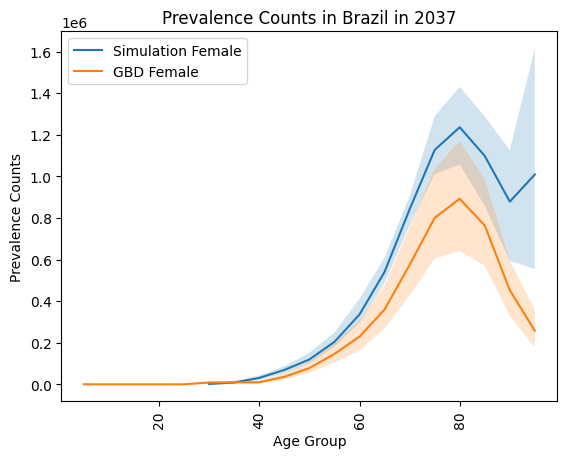

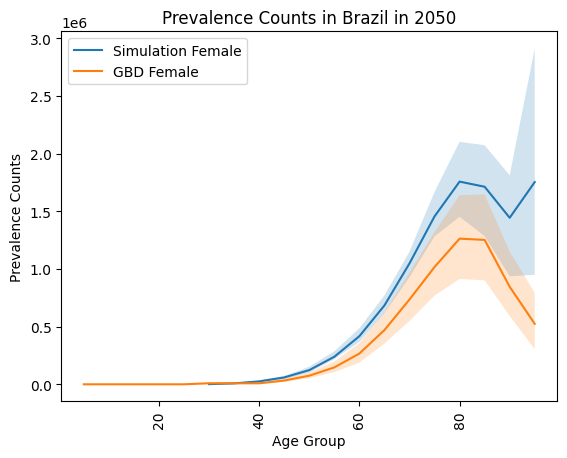

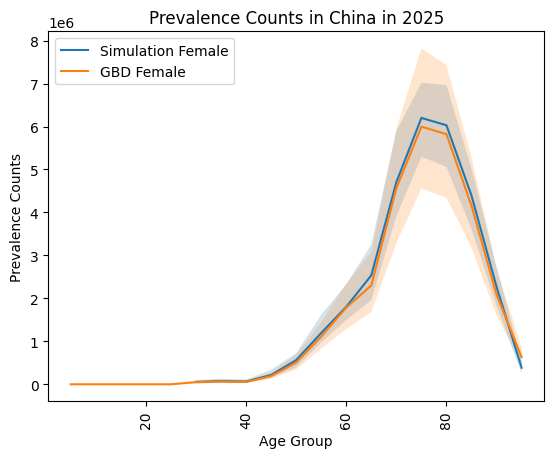

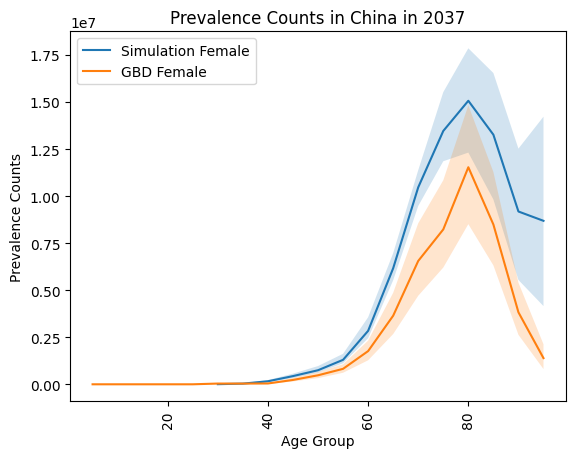

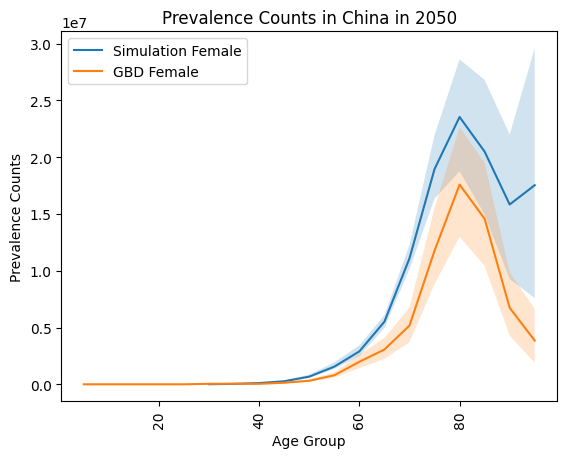

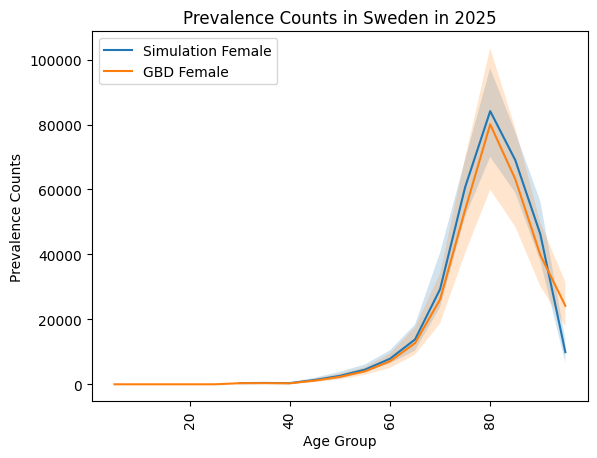

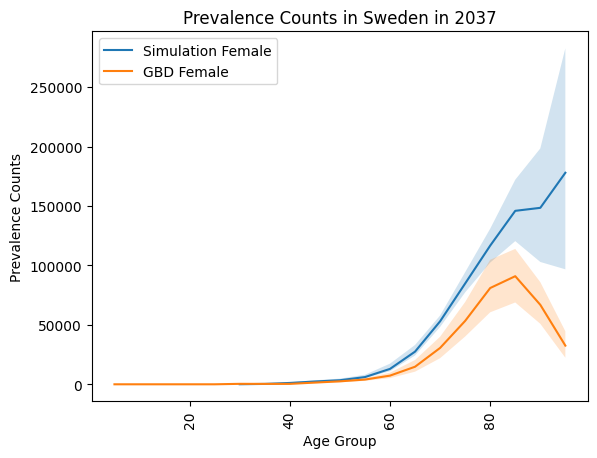

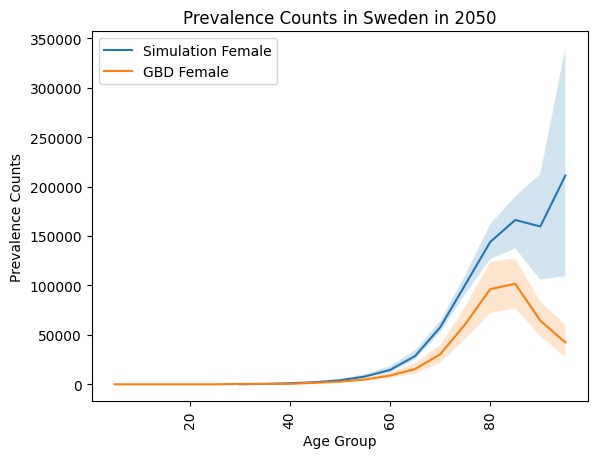

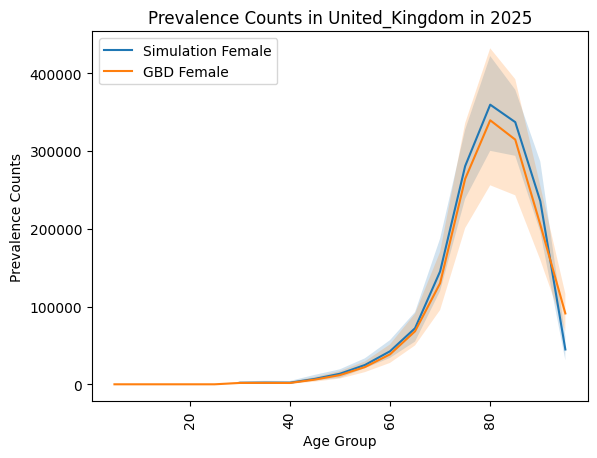

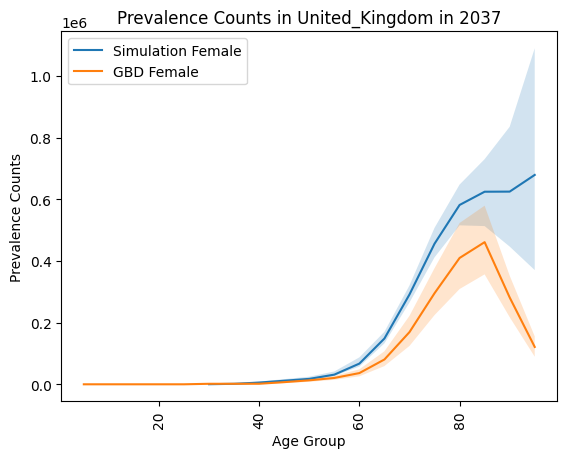

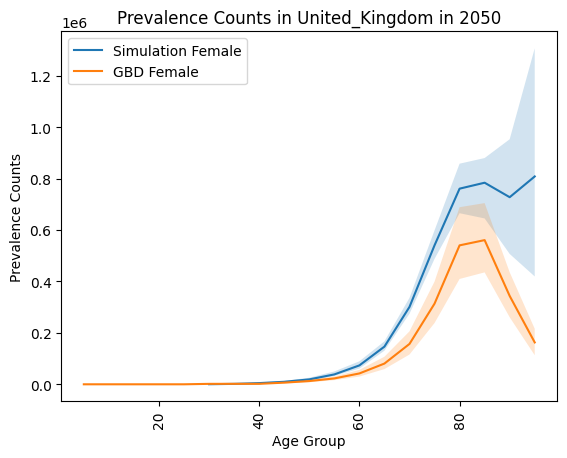

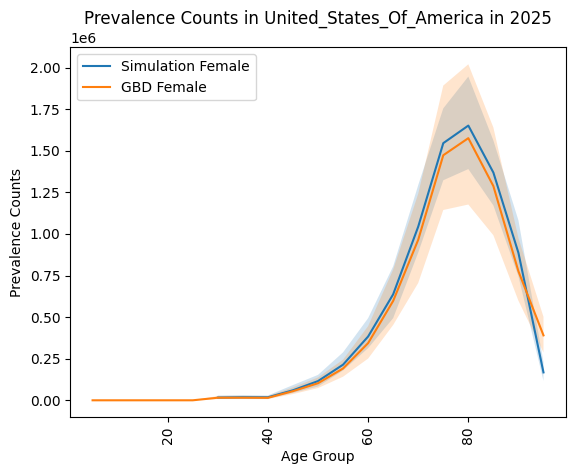

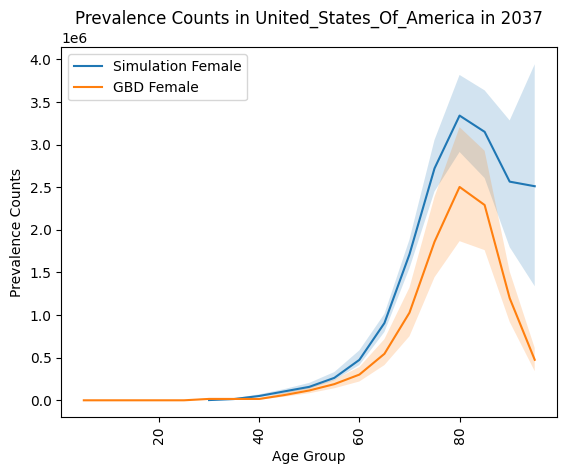

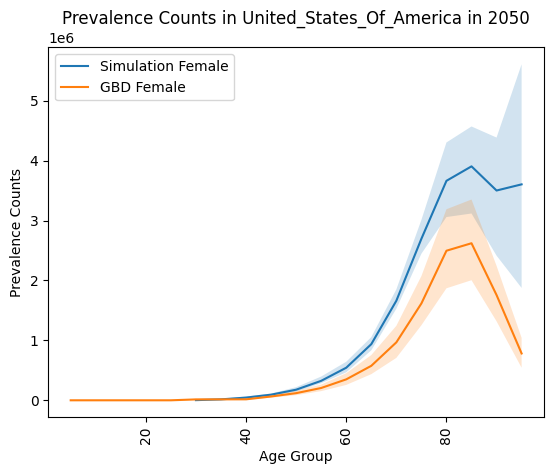

<Figure size 640x480 with 0 Axes>

In [48]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [49]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total#.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,Brazil,25.0,104049.997207,461.377174,103088.747433,103237.251745,103993.601643,104934.128953,105219.112936
1,2025,China,25.0,104492.544066,537.269520,103327.737166,103418.222587,104563.268994,105411.206571,105587.367556
2,2025,Sweden,25.0,105078.424641,820.587662,103414.915811,103754.311294,105070.308008,106630.004107,107256.788501
3,2025,United_Kingdom,25.0,105198.530760,873.405302,103461.511294,103806.618480,105093.355236,106866.488706,107575.942505
4,2025,United_States_Of_America,25.0,104594.753511,663.811977,103200.476386,103462.613552,104521.683778,105855.016016,106332.394251
...,...,...,...,...,...,...,...,...,...,...
375,2100,Brazil,25.0,390721.679179,48756.799337,312643.663244,314684.845996,400358.907598,456804.675154,473919.646817
376,2100,China,25.0,390930.807721,52761.076626,302801.995893,305889.021766,402400.090349,473047.559754,474100.016427
377,2100,Sweden,25.0,286462.192690,34660.204917,223007.983573,227411.106366,287857.872690,339197.476797,351578.948665
378,2100,United_Kingdom,25.0,282766.459466,29066.805744,224498.036961,231406.794251,286789.683778,328141.621355,328436.525667


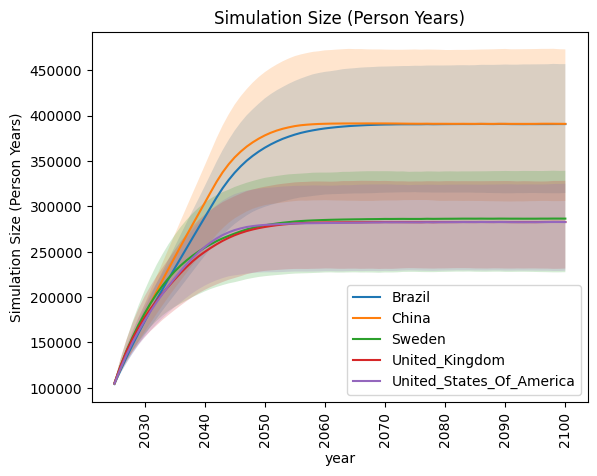

In [50]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()